# DeepHack course on RL. Assignment 4.
# MC. TD. TD($\lambda$)

In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
from gym import wrappers
import numpy as np

import gym
%matplotlib inline

We will use the frozen-lake environment

In [2]:
env = gym.make('FrozenLake8x8-v0')

INFO:gym.envs.registration:Making new env: FrozenLake8x8-v0
[2017-01-02 15:57:18,930] Making new env: FrozenLake8x8-v0


Our goal will be to approximate the value function for the fully-random policy, using three different techniques.

## Monte Carlo
This method uses the following update formula.

$$v(s_t) = v(s_t) + \frac 1 {N(s_t)}(G_t - v(s_t)),$$

where $v$ is the value function, $N(s_t)$ is the number of times the state $s_t$ has been visited and $G_t$ is the return at time step $t$. The method operates as follows. We observe trajectories for the given policy (in case of the on-policy method, which we consider here), and after the end of an episode, we update the value function, according to the specified rule, using the observed values of $G_t$.

In [27]:
env.reset()
env.render()

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)


Let's look, how many times we visit each state for 1000 episodes.

In [24]:
n_runs = 1000
num_visited = np.zeros((env.nS, 1))
for i_episode in range(n_runs):
    num_visited_cur = np.zeros((env.nS, 1))
    observation = env.reset()
    num_visited_cur[observation] = 1
    if not i_episode % 100:
        print('Playing episode:', i_episode)
    for t in range(500):
        
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        num_visited_cur[observation] = 1
        if done:
#             print("Episode finished after {} timesteps".format(t+1))
            break
    num_visited += num_visited_cur
    

Playing episode: 0
Playing episode: 100
Playing episode: 200
Playing episode: 300
Playing episode: 400
Playing episode: 500
Playing episode: 600
Playing episode: 700
Playing episode: 800
Playing episode: 900


In [25]:
num_visited.reshape((8,8))

array([[ 1000.,   822.,   603.,   396.,   237.,   134.,    87.,    63.],
       [  773.,   775.,   672.,   429.,   244.,   141.,   104.,    69.],
       [  572.,   628.,   558.,   507.,   130.,    99.,    79.,    63.],
       [  401.,   447.,   336.,   126.,    68.,    79.,    54.,    39.],
       [  247.,   287.,   209.,   122.,    22.,    13.,    30.,    22.],
       [  132.,   155.,    63.,     3.,     7.,     6.,    18.,     9.],
       [   64.,    48.,     2.,     1.,     4.,     0.,     1.,     5.],
       [   21.,    11.,     5.,     0.,     0.,     0.,     0.,     3.]])

Let's load the actual value function, computed by DP.

In [117]:
true_v = np.load('true_value.npy')

In [122]:
def MC(n_runs, print_freq=0.1, v0=None, true_v=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    n_visited = np.zeros_like(v)
    if true_v is not None:
        v[env.nS-1] = 0
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        visited_cur = np.zeros((env.nS, 1))
        observation = env.reset()
        num_visited_cur[observation] = 1
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        for t in range(500):
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            visited_cur[observation] = 1
            if done:
                break
                
        n_visited += visited_cur
        v[np.where(visited_cur)] += 1/n_visited[np.where(visited_cur)] * (reward - v[np.where(visited_cur)])
        if true_v is not None:
            v[env.nS-1] = 0
            norms.append(np.linalg.norm(v - true_v))
    v[env.nS-1] = 0
    if true_v is not None:
        return v, norms
    return v

In [125]:
v, norms = MC(n_runs=100000, true_v=true_v)

Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


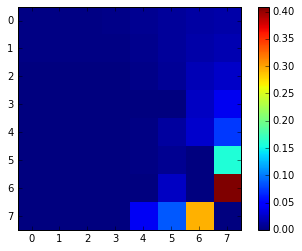

In [126]:
plt.imshow(v.reshape((8,8)), interpolation='nearest')
plt.colorbar()

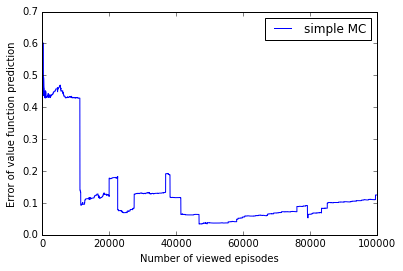

In [127]:
plt.plot(norms, label='simple MC')
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.legend()

In [128]:
simple_mc_norms = norms

#### Constant-$\alpha$ MC

This method uses the following update formula.

$$v(s_t) = v(s_t) + \alpha(G_t - v(s_t)).$$

This method would still converge for a good value of $\alpha$ in case of a slowly changing environment.

In [139]:
def constant_alpha_MC(n_runs, alpha, print_freq=0.1, v0=None, true_v=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    if true_v is not None:
        v[env.nS-1] = 0
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        visited_cur = np.zeros((env.nS, 1))
        observation = env.reset()
        num_visited_cur[observation] = 1
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        for t in range(500):
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            visited_cur[observation] = 1
            if done:
                break
        v[np.where(visited_cur)] += alpha * (reward - v[np.where(visited_cur)])
        if true_v is not None:
            v[env.nS-1] = 0
            norms.append(np.linalg.norm(v - true_v))
    v[env.nS-1] = 0
    if true_v is not None:
        return v, norms
    return v
    

Let's learn the value function with MC method.

In [102]:
v = constant_alpha_MC(n_runs=100000, alpha=1e-1)

(64, 1)
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


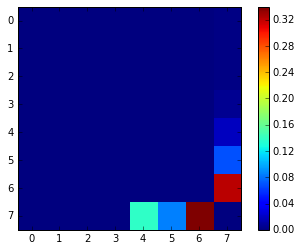

In [106]:
plt.imshow(v.reshape((8,8)), interpolation='nearest')
plt.colorbar()

Now let us compare it with the true value function, computed by DP

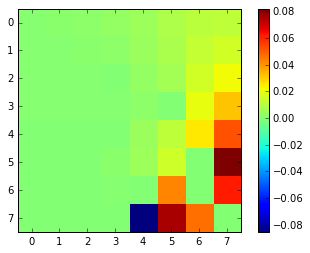

In [107]:
plt.imshow((true_v - v).reshape((8,8)), interpolation='nearest')
plt.colorbar()

Let us compare the method's performance with different alpha

In [109]:
norms_alpha = []
alpha_lst = [.5, .3, .1, 1e-2, 1e-3]
for alpha in alpha_lst:
    print('\talpha=',alpha)
    v, norms = constant_alpha_MC(n_runs=100000, alpha=alpha, true_v=true_v)
    norms_alpha.append(norms)

	alpha= 0.5
(64, 1)
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.3
(64, 1)
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.1
(64, 1)
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.01
(64, 1)
Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000
	alpha= 0.001
(

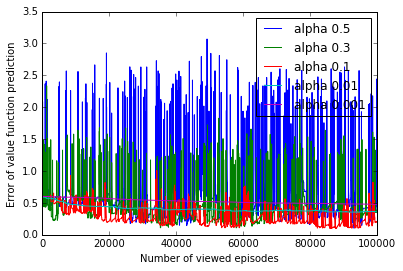

In [129]:
for norms, alpha in list(zip(norms_alpha, alpha_lst)):
    plt.plot(norms, label='alpha '+str(alpha))
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.legend()

Let us compare the best result with simple MC.

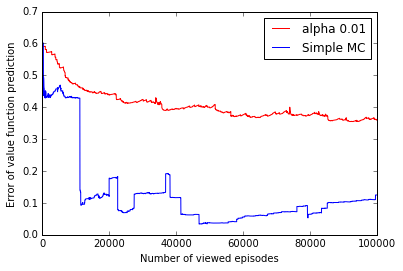

In [135]:
plt.plot(norms_alpha[3], 'r', label='alpha '+str(alpha_lst[3]))
plt.plot(simple_mc_norms, 'b', label='Simple MC')
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.legend()

## Temporal-Difference
This method is similar to constant-$\alpha$ MC, but it "bootstraps". The update rule is given by

$v(s_t) = v(s_t) + \alpha\left(r_{t+1} + \gamma v(s_{t+1}) - v(s_t)\right).$

In [141]:
def td(n_runs, alpha, print_freq=0.1, v0=None, true_v=None):
    norms = []
    v = v0 or np.zeros((env.nS, 1))
    if true_v is not None:
        norms.append(np.linalg.norm(v - true_v))
    for i_episode in range(n_runs):
        observation = env.reset()
        num_visited_cur[observation] = 1
        if not i_episode % int(n_runs * print_freq):
            print('Playing episode:', i_episode)
        
        new_v = np.copy(v)
        for t in range(500):
            action = env.action_space.sample()
            old_observation = observation
            observation, reward, done, info = env.step(action)
            
            new_v[old_observation] += alpha * (reward + v[observation] - v[old_observation])
            if done:
                break
        v = new_v
        if true_v is not None:
            norms.append(np.linalg.norm(v - true_v))
    if true_v is not None:
        return v, norms
    return v

In [147]:
v, norms = td(n_runs=100000, alpha=1e-1, true_v=true_v)

Playing episode: 0
Playing episode: 10000
Playing episode: 20000
Playing episode: 30000
Playing episode: 40000
Playing episode: 50000
Playing episode: 60000
Playing episode: 70000
Playing episode: 80000
Playing episode: 90000


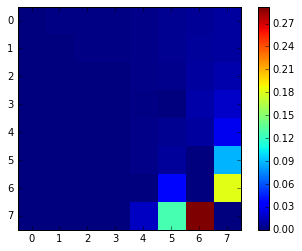

In [148]:
plt.imshow(v.reshape((8,8)), interpolation='nearest')
plt.colorbar()

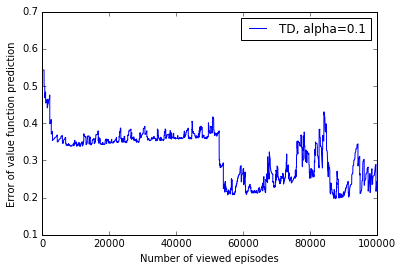

In [150]:
plt.plot(norms, label='TD, alpha=0.1')
plt.ylabel('Error of value function prediction')
plt.xlabel('Number of viewed episodes')
plt.legend()

## TD($\lambda$)
TD($\lambda$) method uses an average of $n$-step returns

$$G^{(n)}_t = r_{t+1} + \gamma r_{t+2} + \ldots + \gamma^{n-1} r_{t+n} + \gamma^n v(s_{t+n}).$$

The $\lambda$-return is defined by 

$$G^{\lambda}_t = (1 - \lambda \sum\limits_{n=1}^{\infty} \lambda^{n-1}G_t^n) = (1 - \lambda \sum\limits_{n=1}^{T - t - 1} \lambda^{n-1}G_t^n) + \lambda^{T - t - 1} G_t,$$
where $T$ is the terminal state.

The method is then defined by
$$v(s_t) = v(s_t) + \alpha \left(G_t^{\lambda} - v(s_t)\right).$$
Note that for $\lambda = 0$ we get the TD method and for $\lambda = 1$ we get the constant-$\alpha$ MC method.
